In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy
from scipy import signal
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.df import streamgapdf, impulse_deltav_plummer_curvedstream
from galpy.util import bovy_conversion, bovy_coords
try:
    reload(galpy.df)
except NameError:
    import galpy.df
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_plot
%pylab inline
R0, V0= 8., 220.

Populating the interactive namespace from numpy and matplotlib


# Some improvements in the streamgapdf code

In [3]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
sigv= 0.365*(10./2.)**(1./3.)
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]])
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),10001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1]),prog_init.y(times[-1]),prog_init.z(times[-1]),
              prog_init.vx(times[-1]),prog_init.vy(times[-1]),prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5]])
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)
sdfl_per_1e8_peri= galpy.df.streamgapdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                        leading=False,nTrackChunks=26,nTrackIterations=0,
                                        sigMeanOffset=4.5,
                                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        Vnorm=V0,Rnorm=R0,
                                        impactb=0.,
                                        subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0, # from Denis' email
                                        timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        impact_angle=-2.34,
                                        GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                        rs=0.625/R0)

## Improved smoothness in the calculated kicks by averaging the Jacobians of nearby points

The kicks are now quite smooth, see the parallel frequency kick (at a few different times here)

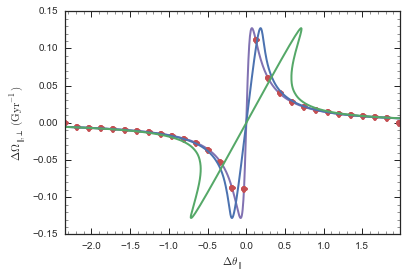

In [4]:
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle+
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*0.88/bovy_conversion.time_in_Gyr(V0,R0),
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*bovy_conversion.freq_in_Gyr(V0,R0),
                    '-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Omega_{\parallel,\perp}\,(\mathrm{Gyr}^{-1})$',
                    yrange=[-0.15,0.15])
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle+
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*5./bovy_conversion.time_in_Gyr(V0,R0),
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*bovy_conversion.freq_in_Gyr(V0,R0),
                    '-',lw=2.,overplot=True)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._gap_thetasTrack-sdfl_per_1e8_peri._impact_angle,
                   sdfl_per_1e8_peri._kick_interpdOpar(sdfl_per_1e8_peri._gap_thetasTrack)*bovy_conversion.freq_in_Gyr(V0,R0),
                    'o',overplot=True,zorder=1)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack-sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_dOaparperp[:,2]*bovy_conversion.freq_in_Gyr(V0,R0),
                    '-',lw=2.,zorder=0,
                    overplot=True)

## Calculation of mean frequency as a function of angle

In [5]:
xs= numpy.linspace(0.,4.5,101)
mO= numpy.array([sdfl_per_1e8_peri.meanOmega(x,oned=True,approx=False) for x in xs])
mO_approx= numpy.array([sdfl_per_1e8_peri.meanOmega(x,oned=True,approx=True) for x in xs])
mO_approx_higherorder= numpy.array([sdfl_per_1e8_peri.meanOmega(x,oned=True,approx=True,higherorder=True) for x in xs])
mO_unp= numpy.array([super(galpy.df.streamgapdf,sdfl_per_1e8_peri).meanOmega(x,oned=True) for x in xs])

Compare to mock simulation, lowess estimate of the trend in the mock data shown in red, agrees with calculation in blue

In [6]:
numpy.random.seed(1)
aa_mock_per= sdfl_per_1e8_peri.sample(n=100000,returnaAdt=True)
Opar= numpy.dot(aa_mock_per[0].T-sdfl_per_1e8_peri._progenitor_Omega,sdfl_per_1e8_peri._dsigomeanProgDirection)
apar= numpy.dot(aa_mock_per[1].T-sdfl_per_1e8_peri._progenitor_angle,sdfl_per_1e8_peri._dsigomeanProgDirection)
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
z = lowess(Opar,apar,frac=0.01)

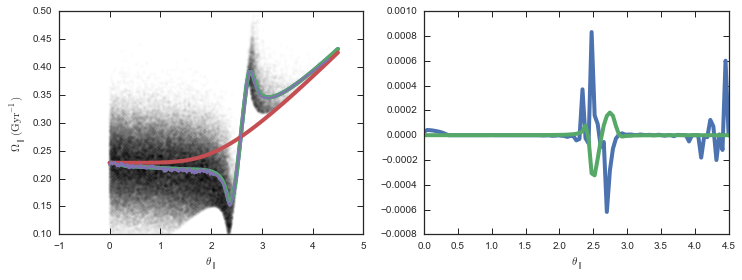

In [7]:
figsize(12,4)
subplot(1,2,1)
plot(apar,Opar*bovy_conversion.freq_in_Gyr(V0,R0),'k.',alpha=0.01)
plot(xs,mO*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_approx*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(z[:,0],z[:,1]*bovy_conversion.freq_in_Gyr(V0,R0),lw=2.)
ylim(0.1,0.5)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')
subplot(1,2,2)
plot(xs,(mO-mO_approx)/mO,lw=4.)
plot(xs,(mO_approx-mO_approx_higherorder)/mO_approx_higherorder,lw=4.)
xlabel(r'$\theta_\parallel$')

In [8]:
import time
start= time.time()
mO_approx= numpy.array([sdfl_per_1e8_peri.meanOmega(x,oned=True,approx=True,higherorder=False) for x in xs])
approxTime= time.time()-start
start= time.time()
mO_approx_higherorder= numpy.array([sdfl_per_1e8_peri.meanOmega(x,oned=True,approx=True,higherorder=True) for x in xs])
approxTime_higherorder= time.time()-start
start= time.time()
mO= numpy.array([sdfl_per_1e8_peri.meanOmega(x,oned=True,approx=False) for x in xs])
print "Speed-up with approximation: %f; time / angle: %f ms" % ((time.time()-start)/approxTime,approxTime/len(xs)*1000.)
print "Speed-up with higher-order approximation: %f; time / angle: %f ms" % ((time.time()-start)/approxTime_higherorder,
                                                                             approxTime_higherorder/len(xs)*1000.)

Speed-up with approximation: 362.685174; time / angle: 0.439752 ms
Speed-up with higher-order approximation: 34.378932; time / angle: 4.639257 ms


## Calculation of density as a function of angle

In [9]:
xs= numpy.linspace(0.,4.5,101)
dens= numpy.array([sdfl_per_1e8_peri.density_par(x,approx=False) for x in xs])
dens_approx= numpy.array([sdfl_per_1e8_peri.density_par(x,approx=True) for x in xs])
dens_approx_higherorder= numpy.array([sdfl_per_1e8_peri.density_par(x,approx=True,higherorder=True) for x in xs])
dens_unp= numpy.array([super(galpy.df.streamgapdf,sdfl_per_1e8_peri)._density_par(x) for x in xs])

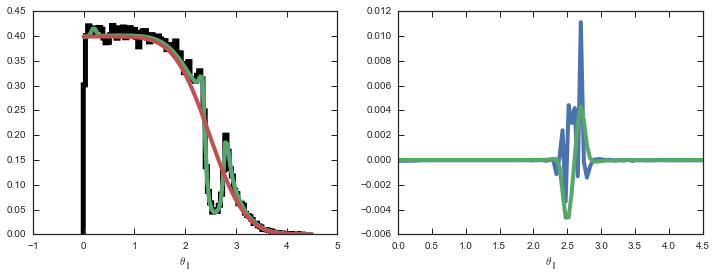

In [10]:
figsize(12,4)
subplot(1,2,1)
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_approx/numpy.sum(dens_approx)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp/numpy.sum(dens_unp)/(xs[1]-xs[0]),lw=4.)
dum= hist(apar,bins=101,normed=True,histtype='step',color='k',zorder=0,lw=5.)
xlabel(r'$\theta_\parallel$')
subplot(1,2,2)
plot(xs,(dens/numpy.sum(dens)/(xs[1]-xs[0])-dens_approx/numpy.sum(dens_approx)/(xs[1]-xs[0]))/(dens/numpy.sum(dens)/(xs[1]-xs[0])),
     lw=4.)
plot(xs,(dens_approx/numpy.sum(dens_approx)/(xs[1]-xs[0])-dens_approx_higherorder/numpy.sum(dens_approx_higherorder)/(xs[1]-xs[0]))/(dens_approx/numpy.sum(dens_approx)/(xs[1]-xs[0])),
     lw=4.)
xlabel(r'$\theta_\parallel$')

In [11]:
import time
start= time.time()
dens_approx= numpy.array([sdfl_per_1e8_peri.density_par(x,approx=True,higherorder=False) for x in xs])
approxTime= time.time()-start
start= time.time()
dens_approx_higherorder= numpy.array([sdfl_per_1e8_peri.density_par(x,approx=True,higherorder=True) for x in xs])
approxTime_higherorder= time.time()-start
start= time.time()
dens= numpy.array([sdfl_per_1e8_peri.density_par(x,approx=False) for x in xs])
print "Speed-up with approximation: %f; time / angle: %f ms" % ((time.time()-start)/approxTime,approxTime/len(xs)*1000.)
print "Speed-up with higher-order approximation: %f; time / angle: %f ms" % ((time.time()-start)/approxTime_higherorder,
                                                                             approxTime_higherorder/len(xs)*1000.)

Speed-up with approximation: 324.333350; time / angle: 0.331791 ms
Speed-up with higher-order approximation: 38.271665; time / angle: 2.811793 ms


## Calculation of density as a function of azimuth

In [12]:
dens_phi= numpy.array([sdfl_per_1e8_peri.density_par(x,coord='phi') for x in sdfl_per_1e8_peri._interpolatedThetasTrack])
RvR= sdfl_per_1e8_peri.sample(n=100000)

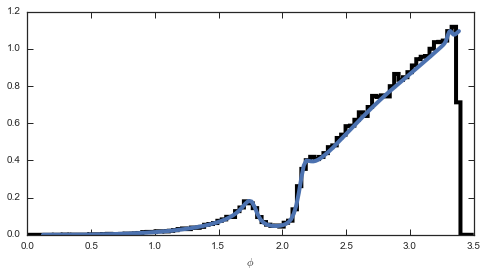

In [13]:
figsize(8,4)
plot((sdfl_per_1e8_peri._interpolatedObsTrack[:,5]-numpy.pi) % (2.*numpy.pi),
     5.*dens_phi/numpy.sum(dens_phi*(
     numpy.roll(sdfl_per_1e8_peri._interpolatedObsTrack[:,5],-1)-sdfl_per_1e8_peri._interpolatedObsTrack[:,5])),
     '-',lw=4.)
dum= hist((RvR[5]-numpy.pi) % (2.*numpy.pi),
          range=[0.,3.5],bins=101,normed=True,histtype='step',lw=4.,color='k')
xlabel(r'$\phi$')

## Map of before and after impact

In $(\Omega_\parallel,\theta_\parallel)$, where are the regions of before and after impact? How smooth is $p(\Omega_\parallel,\theta_\parallel)$?

In [14]:
def beforeAfter(Opar,apar,sdf=sdfl_per_1e8_peri):
    ts= apar/Opar
    apar_impact= apar-Opar*sdf._timpact
    dOpar_impact= sdf._kick_interpdOpar(apar_impact.flatten())
    Opar_b4impact= Opar-numpy.reshape(dOpar_impact,Opar.shape)
    tsb4= apar_impact/Opar_b4impact
    out= numpy.zeros_like(Opar)
    out[ts < sdf._timpact]= 2.
    out[(ts >= sdf._timpact)*(tsb4 < sdf._tdisrupt-sdf._timpact)*(tsb4 > 0.)]= 1.
    return out
def tbefore(Opar,apar,sdf=sdfl_per_1e8_peri):
    ts= apar/Opar
    apar_impact= apar-Opar*sdf._timpact
    dOpar_impact= sdf._kick_interpdOpar(apar_impact.flatten())
    Opar_b4impact= Opar-numpy.reshape(dOpar_impact,Opar.shape)
    tsb4= apar_impact/Opar_b4impact
    return tsb4
def Oparbefore(Opar,apar,sdf=sdfl_per_1e8_peri):
    ts= apar/Opar
    apar_impact= apar-Opar*sdf._timpact
    dOpar_impact= sdf._kick_interpdOpar(apar_impact.flatten())
    Opar_b4impact= Opar-numpy.reshape(dOpar_impact,Opar.shape)
    return Opar_b4impact

/Users/bovy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



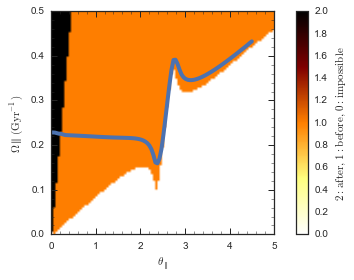

In [15]:
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,5.,101)
bovy_plot.bovy_dens2d(beforeAfter(*numpy.meshgrid(Opars,apars)).T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$\mathrm{2:\ after,\ 1:\ before,\ 0:\ impossible}$')
plot(xs,mO*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega\parallel\,(\mathrm{Gyr}^{-1})$')

## Full 2D probability in $p(\Omega_\parallel,\theta_\parallel)$

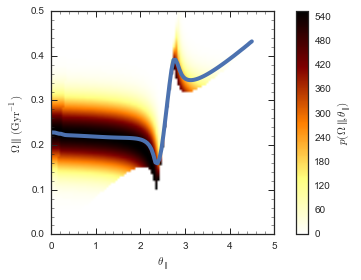

In [16]:
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,5.,101)
y= numpy.array([sdfl_per_1e8_peri.pOparapar(Opars,a) for a in apars])
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(xs,mO*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega\parallel\,(\mathrm{Gyr}^{-1})$')

## Minimum $\Omega_\parallel$ at a given $\theta_\parallel$

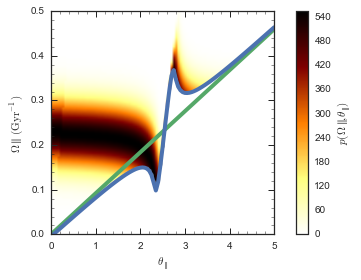

In [17]:
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,5.,101)
lowlim= numpy.array([sdfl_per_1e8_peri.minOpar(da) for da in apars])
y= numpy.array([sdfl_per_1e8_peri.pOparapar(Opars,a) for a in apars])
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(apars,lowlim*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.,zorder=2)
plot(apars,apars/sdfl_per_1e8_peri._tdisrupt*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.,zorder=1)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega\parallel\,(\mathrm{Gyr}^{-1})$')

## Hernquist instead of Plummer kicks

In [18]:
sdfl_per_1e8_peri_hernquist= galpy.df.streamgapdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                        leading=False,nTrackChunks=26,nTrackIterations=0,
                                        sigMeanOffset=4.5,
                                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        Vnorm=V0,Rnorm=R0,
                                        impactb=0.,
                                        subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0, # from Denis' email
                                        timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                        impact_angle=-2.34,
                                        GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                        rs=0.625/R0,
                                                 hernquist=True)

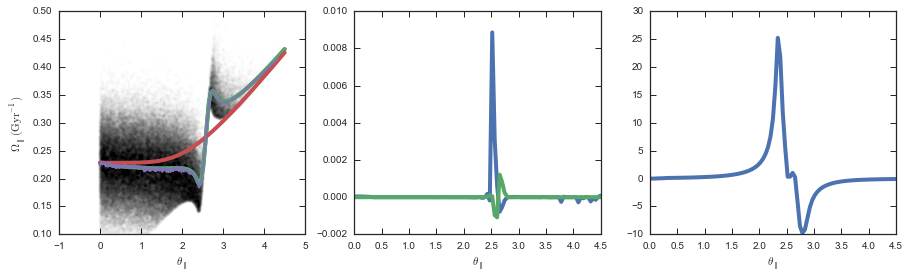

In [19]:
xs= numpy.linspace(0.,4.5,101)
mO_hernquist= numpy.array([sdfl_per_1e8_peri_hernquist.meanOmega(x,oned=True,approx=False) for x in xs])
mO_approx_hernquist= numpy.array([sdfl_per_1e8_peri_hernquist.meanOmega(x,oned=True,approx=True) for x in xs])
mO_approx_higherorder_hernquist= numpy.array([sdfl_per_1e8_peri_hernquist.meanOmega(x,oned=True,approx=True,higherorder=True) for x in xs])
mO_unp_hernquist= numpy.array([super(galpy.df.streamgapdf,sdfl_per_1e8_peri_hernquist).meanOmega(x,oned=True) for x in xs])
numpy.random.seed(1)
aa_mock_per= sdfl_per_1e8_peri_hernquist.sample(n=100000,returnaAdt=True)
Opar= numpy.dot(aa_mock_per[0].T-sdfl_per_1e8_peri_hernquist._progenitor_Omega,sdfl_per_1e8_peri_hernquist._dsigomeanProgDirection)
apar= numpy.dot(aa_mock_per[1].T-sdfl_per_1e8_peri_hernquist._progenitor_angle,sdfl_per_1e8_peri_hernquist._dsigomeanProgDirection)
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
z = lowess(Opar,apar,frac=0.01)
figsize(15,4)
subplot(1,3,1)
plot(apar,Opar*bovy_conversion.freq_in_Gyr(V0,R0),'k.',alpha=0.01)
plot(xs,mO_hernquist*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_approx_hernquist*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp_hernquist*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(z[:,0],z[:,1]*bovy_conversion.freq_in_Gyr(V0,R0),lw=2.)
ylim(0.1,0.5)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')
subplot(1,3,2)
plot(xs,(mO_hernquist-mO_approx_hernquist)/mO,lw=4.)
plot(xs,(mO_approx_hernquist-mO_approx_higherorder_hernquist)/mO_approx_higherorder_hernquist,lw=4.)
xlabel(r'$\theta_\parallel$')
subplot(1,3,3)
plot(xs,(mO_approx_higherorder_hernquist-mO_approx_higherorder)/mO_approx_higherorder*100.,lw=4.)
xlabel(r'$\theta_\parallel$')

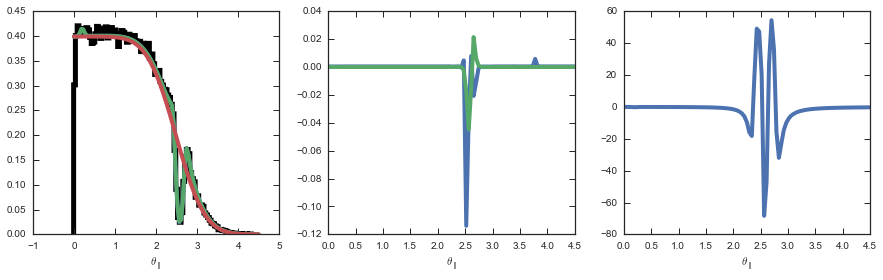

In [20]:
xs= numpy.linspace(0.,4.5,101)
dens_hernquist= numpy.array([sdfl_per_1e8_peri_hernquist.density_par(x,approx=False) for x in xs])
dens_approx_hernquist= numpy.array([sdfl_per_1e8_peri_hernquist.density_par(x,approx=True) for x in xs])
dens_approx_higherorder_hernquist= numpy.array([sdfl_per_1e8_peri_hernquist.density_par(x,approx=True,higherorder=True) for x in xs])
dens_unp_hernquist= numpy.array([super(galpy.df.streamgapdf,sdfl_per_1e8_peri_hernquist)._density_par(x) for x in xs])
figsize(15,4)
subplot(1,3,1)
plot(xs,dens_hernquist/numpy.sum(dens_hernquist)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_approx_hernquist/numpy.sum(dens_approx_hernquist)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp_hernquist/numpy.sum(dens_unp_hernquist)/(xs[1]-xs[0]),lw=4.)
dum= hist(apar,bins=101,normed=True,histtype='step',color='k',zorder=0,lw=5.)
xlabel(r'$\theta_\parallel$')
subplot(1,3,2)
plot(xs,(dens_hernquist/numpy.sum(dens_hernquist)/(xs[1]-xs[0])-dens_approx_hernquist/numpy.sum(dens_approx_hernquist)/(xs[1]-xs[0]))/(dens/numpy.sum(dens_hernquist)/(xs[1]-xs[0])),
     lw=4.)
plot(xs,(dens_approx_hernquist/numpy.sum(dens_approx_hernquist)/(xs[1]-xs[0])-dens_approx_higherorder_hernquist/numpy.sum(dens_approx_higherorder_hernquist)/(xs[1]-xs[0]))/(dens_approx_hernquist/numpy.sum(dens_approx_hernquist)/(xs[1]-xs[0])),
     lw=4.)
xlabel(r'$\theta_\parallel$')
subplot(1,3,3)
plot(xs,100.*(dens_approx_higherorder_hernquist/numpy.sum(dens_approx_higherorder_hernquist)/(xs[1]-xs[0])-dens_approx_higherorder/numpy.sum(dens_approx_higherorder)/(xs[1]-xs[0]))/(dens_approx_higherorder_hernquist/numpy.sum(dens_approx_higherorder_hernquist)/(xs[1]-xs[0])),
     lw=4.)
xlabel(r'$\theta_\parallel$')

In [21]:
import time
start= time.time()
mO_approx_hernquist= numpy.array([sdfl_per_1e8_peri_hernquist.meanOmega(x,oned=True,approx=True,higherorder=False) for x in xs])
approxTime= time.time()-start
start= time.time()
mO_approx_higherorder_hernquist= numpy.array([sdfl_per_1e8_peri_hernquist.meanOmega(x,oned=True,approx=True,higherorder=True) for x in xs])
approxTime_higherorder= time.time()-start
start= time.time()
mO_hernquist= numpy.array([sdfl_per_1e8_peri.meanOmega(x,oned=True,approx=False) for x in xs])
print "Speed-up with approximation: %f; time / angle: %f ms" % ((time.time()-start)/approxTime,approxTime/len(xs)*1000.)
print "Speed-up with higher-order approximation: %f; time / angle: %f ms" % ((time.time()-start)/approxTime_higherorder,
                                                                             approxTime_higherorder/len(xs)*1000.)

Speed-up with approximation: 208.216155; time / angle: 0.875355 ms
Speed-up with higher-order approximation: 39.926962; time / angle: 4.564942 ms


In [22]:
import time
start= time.time()
dens_approx_hernquist= numpy.array([sdfl_per_1e8_peri.density_par(x,approx=True,higherorder=False) for x in xs])
approxTime= time.time()-start
start= time.time()
dens_approx_higherorder_hernquist= numpy.array([sdfl_per_1e8_peri.density_par(x,approx=True,higherorder=True) for x in xs])
approxTime_higherorder= time.time()-start
start= time.time()
dens_hernquist= numpy.array([sdfl_per_1e8_peri.density_par(x,approx=False) for x in xs])
print "Speed-up with approximation: %f; time / angle: %f ms" % ((time.time()-start)/approxTime,approxTime/len(xs)*1000.)
print "Speed-up with higher-order approximation: %f; time / angle: %f ms" % ((time.time()-start)/approxTime_higherorder,
                                                                             approxTime_higherorder/len(xs)*1000.)

Speed-up with approximation: 590.871904; time / angle: 0.213177 ms
Speed-up with higher-order approximation: 78.279699; time / angle: 1.609118 ms
